In [6]:
#Importation of MONAI and other dependencies

%matplotlib inline

from urllib.request import urlopen
from io import BytesIO

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import progress_bar
from monai.transforms import (
    Transform,
    Compose,
    AddChannel,
    ScaleIntensity,
    ToTensor
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

batch_size = 300  # changed
num_workers = 10  # changed
num_epochs = 600
lr = 5e-4  # changed

(420, 64, 64) (420, 64, 64)


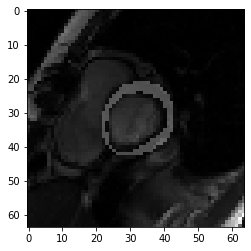

In [7]:
#Download and visualization of the data

remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())
data = np.load(npz)  # load all the data from the archive

images = data["images"]  # images in BHW array order
segs = data["segs"]  # segmentations in BHW array order
case_indices = data["caseIndices"]  # the indices in `images` for each case

images = images.astype(np.float32) / images.max()  # normalize images

print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

In [8]:
#Split of the data into training and validations sets. The last 6 cases will be for testing

test_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:test_index], segs[:test_index]
test_images, test_segs = images[test_index:], segs[test_index:]


torch.Size([300, 1, 64, 64]) tensor(0.) tensor(1.) torch.Size([300, 1, 64, 64])


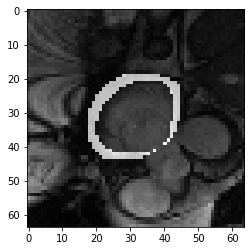

In [9]:
#Creating a data loading object to compose batches during the training and another for validation.

# The solution here does two things: introduce random augmentations and converting the training pipeline to be based on
# dictionaries. This lets us use the CacheDataset type more easily with two part data (image/segmentation).

from monai.data import CacheDataset
from monai.transforms import (
    AddChanneld,
    ScaleIntensityd,
    ToTensord,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)

aug_prob = 0.5
keys = ("img", "seg")

# use these when interpolating binary segmentations to ensure values are 0 or 1 only
zoom_mode = monai.utils.enums.InterpolateMode.NEAREST
elast_mode = monai.utils.enums.GridSampleMode.BILINEAR, monai.utils.enums.GridSampleMode.NEAREST


trans = Compose(
    [
        ScaleIntensityd(keys=("img",)),  # rescale image data to range [0,1]
        AddChanneld(keys=keys),  # add 1-size channel dimension
        RandRotate90d(keys=keys, prob=aug_prob),
        RandFlipd(keys=keys, prob=aug_prob),
        RandZoomd(keys=keys, prob=aug_prob, mode=zoom_mode),
        Rand2DElasticd(keys=keys, prob=aug_prob, spacing=10, magnitude_range=(-2, 2), mode=elast_mode),
        RandAffined(keys=keys, prob=aug_prob, rotate_range=1, translate_range=16, mode=elast_mode),
        ToTensord(keys=keys),  # convert to tensor
    ]
)


data = [
    {"img": train_images[i], "seg": train_segs[i]} for i in range(len(train_images))
]

ds = CacheDataset(data, trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# for simplicity we'll keep the existing pipeline for the validation data since it doesn't have any augmentations

val_image_trans = Compose([ScaleIntensity(), AddChannel(), ToTensor(),])

val_seg_trans = Compose([AddChannel(), ToTensor()])


val_ds = ArrayDataset(test_images, val_image_trans, test_segs, val_seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

# %timeit first(loader)

batch = first(loader)
im = batch["img"]
seg = batch["seg"]
print(im.shape, im.min(), im.max(), seg.shape)
plt.imshow(im[0, 0].numpy() + seg[0, 0].numpy(), cmap="gray")



In [10]:
#Using UNet for the segmentation network
#Training scheme: For each epoch the training is made on each batch of iamges from the training set, assim the training is made with each image once, and then is evaluated with the validation set.

net = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    #     num_res_units=2,
    dropout=0.1,
)

net = net.to(device)

opt = torch.optim.Adam(net.parameters(), lr)
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(
    include_background=True, to_onehot_y=False, sigmoid=True, reduction="mean"
)

step_losses = []
epoch_metrics = []
total_step = 0

for epoch in range(num_epochs):
    net.train()

    # train network with training images
    for batch in loader:
        bimages = batch["img"].to(device)
        bsegs = batch["seg"].to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(prediction, bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    # test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            prediction = net(bimages)
            pred_metric = metric(prediction, bsegs)
            metric_vals.append(pred_metric.item())

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:.3}")

/600 Validation Metric: 0.5 [====                          ]95/600 Validation Metric: 0.504 [====                          ]97/600 Validation Metric: 0.506 [====                          ]99/600 Validation Metric: 0.508 [====                          ]101/600 Validation Metric: 0.512 [=====                         ]103/600 Validation Metric: 0.514 [=====                         ]105/600 Validation Metric: 0.515 [=====                         ]107/600 Validation Metric: 0.52 [=====                         ]109/600 Validation Metric: 0.521 [=====                         ]111/600 Validation Metric: 0.525 [=====                         ]113/600 Validation Metric: 0.527 [=====                         ]115/600 Validation Metric: 0.526 [=====                         ]117/600 Validation Metric: 0.532 [=====                         ]119/600 Validation Metric: 0.531 [=====                         ]121/600 Validation Metric: 0.536 [======                        ]123/600 Validation Metric: 0.537 [

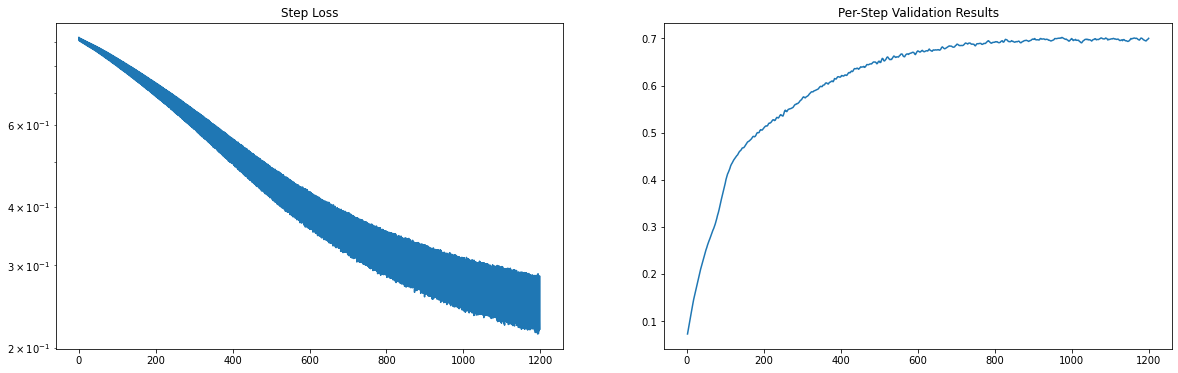

In [11]:
#Graph the results

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()
